 This project will explore house prices in major cities around ontario

- Import packages and read in csvs scraped using Octoparse
- Append all dataframes into one dataframe

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from dateutil.relativedelta import relativedelta
%matplotlib inline

In [4]:
osh = pd.read_csv('Oshawahomes.csv')
oak = pd.read_csv('Oakhomes.csv')
markh = pd.read_csv('Markhamhomes.csv')
whit = pd.read_csv('Whitbyhomes.csv')
rich = pd.read_csv('Richmondhomes.csv')
newm = pd.read_csv('Newmhomes.csv')
ajaxh = pd.read_csv('Ajaxhomes.csv')
milt = pd.read_csv('Miltonhomes.csv')
vaug = pd.read_csv('Vaughanhomes.csv')
brap = pd.read_csv('Bramptonhomes.csv')
burl = pd.read_csv('Burlingtonhomes.csv')
missi = pd.read_csv('Missihomes.csv')

In [49]:
#append the dataframes to form 1 record 
houses = pd.DataFrame().append([osh,oak, markh,whit,rich,newm,ajaxh,milt,vaug,brap,burl,missi])
houses.shape

(53632, 10)

In [50]:
houses.head()

,Title,Title_URL,Image,Tag,Price,Price1,style_component__qn84q,style_listingdetail__b0bdg,style_listingdetail__b0bdg2,style_listingdetail__b0bdg3
0,362 Newgate Ave,https://www.zoocasa.com/oshawa-on-real-estate/...,https://www.zoocasa.com/_next/image?url=https%...,Sold,"$930,000","List Price$950,000",2 days,3 Bed,2 Bath,1500–2000 sqft
1,1488 Fenelon Cres,https://www.zoocasa.com/oshawa-on-real-estate/...,https://www.zoocasa.com/_next/image?url=https%...,Sold,"$730,000","List Price$699,000",3 days,3 Bed,2 Bath,N/A sqft
2,536 Park Rd S,https://www.zoocasa.com/oshawa-on-real-estate/...,https://www.zoocasa.com/_next/image?url=https%...,Sold,"$715,000","List Price$759,300",2 days,3 Bed,3 Bath,N/A sqft
3,292 Elgin St W,https://www.zoocasa.com/oshawa-on-real-estate/...,https://www.zoocasa.com/_next/image?url=https%...,Sold,"$585,880","List Price$599,000",Sold 2 Days Ago,2 Bed,2 Bath,N/A sqft
4,148 Colborne St E,https://www.zoocasa.com/oshawa-on-real-estate/...,https://www.zoocasa.com/_next/image?url=https%...,Sold,"$698,000","List Price$658,000",3 days,3 Bed,1 Bath,N/A sqft


Checking the datatype for the columns
some columns need to be renamed and cleaned 

In [8]:
#check data types for different columns 
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53632 entries, 0 to 10268
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Title                        53632 non-null  object
 1   Title_URL                    53632 non-null  object
 2   Image                        53623 non-null  object
 3   Tag                          53632 non-null  object
 4   Price                        53632 non-null  object
 5   Price1                       53632 non-null  object
 6   style_component__qn84q       53632 non-null  object
 7   style_listingdetail__b0bdg   53632 non-null  object
 8   style_listingdetail__b0bdg2  53632 non-null  object
 9   style_listingdetail__b0bdg3  53632 non-null  object
dtypes: object(10)
memory usage: 4.5+ MB


In [9]:
houses.columns

Index(['Title', 'Title_URL', 'Image', 'Tag', 'Price', 'Price1',
       'style_component__qn84q', 'style_listingdetail__b0bdg',
       'style_listingdetail__b0bdg2', 'style_listingdetail__b0bdg3'],
      dtype='object')

In [106]:
houses_clean = houses.copy()

In [107]:
#keep relevant columns
houses_clean = houses_clean[['Title','Title_URL','Price','Price1','style_listingdetail__b0bdg','style_listingdetail__b0bdg2','style_listingdetail__b0bdg3','style_component__qn84q']]

In [108]:
#rename columns

dict = {'Title':'Street','Title_URL':'Street_URL',
        'Price': 'SoldPrice',
        'Price1':'ListPrice','style_listingdetail__b0bdg':'Bed',
       'style_listingdetail__b0bdg2':'Bath','style_listingdetail__b0bdg3':'Size',
       'style_component__qn84q':'SoldTime'}

houses_clean.rename(columns=dict,
          inplace=True)

In [109]:
#reorder columns
houses_clean = houses_clean[[ 'ListPrice','SoldPrice','SoldTime','Bed','Bath','Size','Street', 'Street_URL']]

In [110]:
houses_clean.head()

,ListPrice,SoldPrice,SoldTime,Bed,Bath,Size,Street,Street_URL
0,"List Price$950,000","$930,000",2 days,3 Bed,2 Bath,1500–2000 sqft,362 Newgate Ave,https://www.zoocasa.com/oshawa-on-real-estate/...
1,"List Price$699,000","$730,000",3 days,3 Bed,2 Bath,N/A sqft,1488 Fenelon Cres,https://www.zoocasa.com/oshawa-on-real-estate/...
2,"List Price$759,300","$715,000",2 days,3 Bed,3 Bath,N/A sqft,536 Park Rd S,https://www.zoocasa.com/oshawa-on-real-estate/...
3,"List Price$599,000","$585,880",Sold 2 Days Ago,2 Bed,2 Bath,N/A sqft,292 Elgin St W,https://www.zoocasa.com/oshawa-on-real-estate/...
4,"List Price$658,000","$698,000",3 days,3 Bed,1 Bath,N/A sqft,148 Colborne St E,https://www.zoocasa.com/oshawa-on-real-estate/...


In [112]:
#strip numeric columns of unwanted characters and convert to numeric
#will deal with size seperately

cols = ['ListPrice','SoldPrice','Bed','Bath']

houses_clean[cols]=houses_clean[cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[cols] = houses_clean[cols].apply(pd.to_numeric, errors='coerce')

In [113]:
houses_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53632 entries, 0 to 10268
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ListPrice   53632 non-null  int64 
 1   SoldPrice   53632 non-null  int64 
 2   SoldTime    53632 non-null  object
 3   Bed         53632 non-null  int64 
 4   Bath        53632 non-null  int64 
 5   Size        53632 non-null  object
 6   Street      53632 non-null  object
 7   Street_URL  53632 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.7+ MB


- Size has a range so I'll take the mean of the two numbers to get a size gives an estimate of the size. 
- I'll fill the NA with the mean of the sizes because that's one way to deal with missing values(another is to remove them but I won't be doing that) 

In [118]:
#split original size column
houses_clean[['A', 'B']] = houses_clean['Size'].str.split('–', 1, expand=True)


In [132]:
#replace non digits, convert to numeric and then get mean of both numbers
sz_cols = ['A','B']

houses_clean[sz_cols]=houses_clean[sz_cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[sz_cols] = houses_clean[sz_cols].apply(pd.to_numeric, errors='coerce')
houses_clean['sqft'] = houses_clean[['A', 'B']].mean(axis=1)

#replace na with mean 
mean = np.mean(houses_clean['sqft'])
houses_clean['sqft']=houses_clean['sqft'].fillna(mean)

In [ ]:
#drop original size column and A, B
houses_clean.drop(columns=['Size','A','B'], axis=1, inplace=True)

Need to find the cities of the house. This is somewhere in the street url after '.com'

In [129]:
#split street url by / and select the last index e.g 'oshawa-on-real-estate'
houses_clean['Street_URL']= houses_clean['Street_URL'].apply(lambda x: x.split('/')[3])

#replace to get just the city and rename col
houses_clean['Street_URL']=houses_clean['Street_URL'].apply(lambda x: x.replace('-on-real-estate',''))
houses_clean.rename(columns={'Street_URL': 'City'}, inplace=True)


In [134]:
houses_clean.head()

,ListPrice,SoldPrice,SoldTime,Bed,Bath,Street,City,sqft
0,950000,930000,2 days,3,2,362 Newgate Ave,oshawa,1750.000000
1,699000,730000,3 days,3,2,1488 Fenelon Cres,oshawa,1811.364667
2,759300,715000,2 days,3,3,536 Park Rd S,oshawa,1811.364667
3,599000,585880,Sold 2 Days Ago,2,2,292 Elgin St W,oshawa,1811.364667
4,658000,698000,3 days,3,1,148 Colborne St E,oshawa,1811.364667


- SoldTime needs to be cleaned 
- During the scraping, I could not get the actual date the houses were sold, so I will do an estimate using the sold time. I will subtract the soldTime from the date I scraped the data. I only need the year and month. 

In [135]:
#I'll check what values are there so I can determine best way to clean it
houses_clean['SoldTime'].value_counts()


11 months           4125
2 months            3916
10 months           3488
7 months            3336
6 months            3275
                    ... 
Sold 14 Days Ago      17
Sold 15 Days Ago      16
Sold 22 Days Ago      15
Sold 2 Days Ago        5
21 hours               3
Name: SoldTime, Length: 85, dtype: int64

In [148]:
#replace ago and sold . so I just have days, months, and year
houses_clean['SoldTime']=houses_clean['SoldTime'].str.replace('Sold','')
houses_clean['SoldTime']= houses_clean['SoldTime'].str.replace('Ago','')

In [336]:
#this lambda function subtracts the days/month/year/hours from the date that the data was scraped (extract_date)
extract_date = datetime.date('2022','04','30')
houses_clean["SoldDate"] = houses_clean['SoldTime'].apply(lambda x: extract_date - datetime.timedelta(days=int(re.search(r'\d+',x).group())) 
                                   if (('days' in x.lower()) or ('Day' in x.lower()) ) 
                                   else (extract_date - relativedelta(months=int(re.search(r'\d+',x).group())) 
                                    if (('months' in x.lower()) or ('month' in x.lower())) 
                                     else (extract_date - relativedelta(years=int(re.search(r'\d+',x).group()))
                                    if (('years' in x.lower()) or ('year' in x.lower()))    
                                    else (extract_date if 'hours' in x.lower() else ' '))))
                                       


In [339]:
#extract the month and year from the solddate
houses_clean['SoldDate'] = pd.to_datetime(houses_clean['SoldDate'])
houses_clean['month_year'] = houses_clean['SoldDate'].dt.to_period('M')
houses_clean.head()

,ListPrice,SoldPrice,SoldTime,Bed,Bath,Street,City,sqft,SoldDate,month_year
0,950000,930000,2 days,3,2,362 Newgate Ave,oshawa,1750.000000,2022-04-28,2022-04
1,699000,730000,3 days,3,2,1488 Fenelon Cres,oshawa,1811.364667,2022-04-27,2022-04
2,759300,715000,2 days,3,3,536 Park Rd S,oshawa,1811.364667,2022-04-28,2022-04
3,599000,585880,2 Days,2,2,292 Elgin St W,oshawa,1811.364667,2022-04-28,2022-04
4,658000,698000,3 days,3,1,148 Colborne St E,oshawa,1811.364667,2022-04-27,2022-04


# Lets Explore

In [341]:
houses_clean.describe()

,ListPrice,SoldPrice,Bed,Bath,sqft
count,5.363200e+04,5.363200e+04,53632.000000,53632.000000,53632.000000
mean,1.092863e+06,1.188893e+06,3.080996,3.024724,1811.364667
std,6.302489e+05,6.207244e+05,0.961648,1.212248,756.835906
min,1.000000e+00,2.000000e+05,0.000000,1.000000,499.000000
25%,6.999990e+05,7.950000e+05,3.000000,2.000000,1300.000000
50%,9.499000e+05,1.060000e+06,3.000000,3.000000,1811.364667
75%,1.299000e+06,1.420000e+06,4.000000,4.000000,1811.364667
max,2.188800e+07,1.976000e+07,9.000000,16.000000,5000.000000


-  Looking at the data above, we can see a max Bath number of 16, and since I am not a millionaire(yet)for the purpose of this project(my house hunting journey) I would be limiting the dataset to properties with 2 -4 Bedrooms
- This falls within my budget(I hope) as well as its what's affordable for a lot of people given the craziness of the house market 
- It would also help in getting rid of outliers that could skew the mean which would help with predictions
- Before we limit the dataset lets see what the distribution of the soldPrice variable looks like

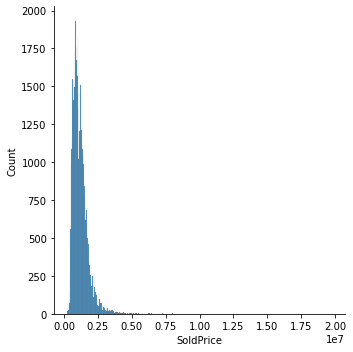

In [342]:
sns.displot( x="SoldPrice", data = houses_clean)

Rightly skewed with some outliers to the right, lets see this with a box and whisker plot

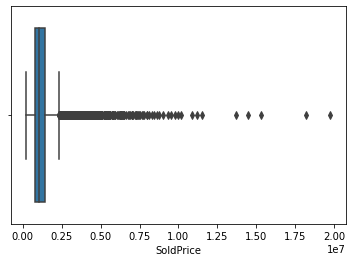

In [344]:
sns.boxplot(x=houses_clean["SoldPrice"])
plt.show()

Lets remove those high number bedrooms to see if we can get a better distribution